In [28]:
# Parallel Convolutional Neural Network for multi-class softmax classification

In [29]:
# Import the dependencies

%matplotlib inline
import matplotlib.pyplot as plt #For plots
import pandas as pd #For Dataframes
import numpy as np #For scientific computing 

In [30]:
# Import Keras dependencies

import keras

from keras.models import Sequential, load_model, Model
from keras.utils import to_categorical
from keras import layers
from keras import Input
# from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [31]:
batch_size = 256
num_classes = 10
epochs = 10
img_rows, img_cols = 28, 28    # Input image dimensions

In [32]:
Emnist_file_path = "emnist/"

In [33]:
All_train = Emnist_file_path + 'emnist-digits-train.csv'
All_test = Emnist_file_path + 'emnist-digits-test.csv'

In [34]:
All_train_data = pd.read_csv(All_train)
All_test_data = pd.read_csv(All_test)

In [35]:
All_training_data = All_train_data.values
All_testing_data = All_test_data.values

In [36]:
print(type(All_training_data))
print(type(All_testing_data))
print(All_training_data.shape)
print(All_testing_data.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(239999, 785)
(39999, 785)


In [37]:
x_train = All_training_data[:, 1:].astype('float32')
y_train = All_training_data[:, 0:1]
print('x_train shape : ', x_train.shape)
print('y_train shape : ', y_train.shape)

x_train shape :  (239999, 784)
y_train shape :  (239999, 1)


In [38]:
x_test = All_testing_data[:, 1:].astype('float32')
y_test = All_testing_data[:, 0:1]
print('x_test shape : ', x_test.shape)
print('y_test shape : ', y_test.shape)

x_test shape :  (39999, 784)
y_test shape :  (39999, 1)


In [39]:
# for conv2d
x_train = np.array(list(map(lambda x : x.reshape(28, 28).transpose().reshape(28, 28, 1), x_train)))
x_test = np.array(list(map(lambda x : x.reshape(28, 28).transpose().reshape(28, 28, 1), x_test)))

In [40]:
input_shape = (img_rows, img_cols, 1)

In [41]:
print(type(x_train))
print('x_train shape : ', x_train.shape)

<class 'numpy.ndarray'>
x_train shape :  (239999, 28, 28, 1)


In [42]:
print(type(x_test))
print('x_test shape : ', x_test.shape)

<class 'numpy.ndarray'>
x_test shape :  (39999, 28, 28, 1)


data  9008  :  [3]


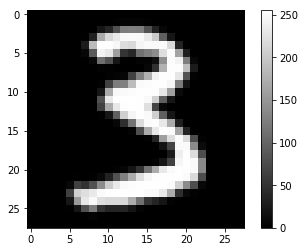

In [43]:
# Print the i data 
i = 9008
plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
plt.colorbar()
print('data ', i, ' : ', y_test[i])

In [44]:
# Make it 0 based indices

y_train = y_train - 1
y_test = y_test - 1

In [45]:
# Scale from 0 to 255

x_train /= 255
x_test /= 255

In [46]:
# Convert labels to categorical one-hot encoding

y_train = keras.utils.to_categorical(y_train, num_classes)

y_test = keras.utils.to_categorical(y_test, num_classes)

In [47]:
# # Set the CNN Architecture

# model = Sequential()
# # filters: Integer (Here 32), the dimensionality of the output space (i.e. the number of output filters in the convolution).
# # kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. 
# # Can be a single integer to specify the same value for all spatial dimensions.
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(num_classes, activation='softmax'))

In [48]:
# # for conv2D
# model = Sequential()
# model.add(Conv2D(64, (5, 5),input_shape=(28, 28, 1), activation='relu'))
# model.add(MaxPooling2D((2, 2), (2, 2)))
# model.add(Flatten())
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'),)
# model.add(Dense(num_classes, activation='softmax'))

In [49]:
# Set the CNN Architecture
input_tensor = Input(shape=input_shape)

#input_noisy = layers.GaussianNoise(.25)(input_tensor)

branch_a = layers.Conv2D(64, (2,6), activation='relu')(input_tensor)
branch_a = layers.AveragePooling2D(pool_size=(2,2))(branch_a)
branch_a = layers.Conv2D(64, (2,2), activation='relu')(branch_a)
branch_a = layers.MaxPooling2D(pool_size=(2,2))(branch_a)
branch_a = layers.Dropout(0.25)(branch_a)
#branch_a = Flatten()(branch_a)

branch_b = layers.Conv2D(64, (6,2), activation='relu')(input_tensor)
branch_b = layers.AveragePooling2D(pool_size=(2,2))(branch_b)
branch_b = layers.Conv2D(64, (2,2), activation='relu')(branch_b)
branch_b = layers.MaxPooling2D(pool_size=(2,2))(branch_b)
branch_b = layers.Dropout(0.25)(branch_b)
branch_b = layers.Reshape((6, 5, 64))(branch_b)
#branch_b = Flatten()(branch_b)

branch_ab = layers.concatenate([branch_a, branch_b], axis=-1)
branch_ab = layers.LocallyConnected2D(64, (3,3), activation='relu')(branch_ab)
branch_ab = layers.Dropout(0.25)(branch_ab)

branch_ab = layers.Flatten()(branch_ab)

dense_layer = layers.Dense(512, activation='relu')(branch_ab)
dense_layer = layers.Dropout(0.25)(dense_layer)
dense_layer = layers.Dense(512, activation='relu')(dense_layer)
dense_layer = layers.Dropout(0.25)(dense_layer)
dense_layer = layers.Dense(128, activation='relu')(dense_layer)
dense_layer = layers.Dropout(0.25)(dense_layer)
dense_layer = layers.Dense(128, activation='relu')(dense_layer)
dense_layer = layers.Dropout(0.25)(dense_layer)

output_tensor = layers.Dense(num_classes, activation='softmax')(dense_layer)

model = Model(input_tensor, output_tensor)

In [50]:
# Compile the Model

# model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
# model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

In [51]:
# We can summarize our model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 23, 27, 64)   832         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 27, 23, 64)   832         input_2[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 11, 13, 64)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
average_po

In [52]:
# Calculate the Classification Accuracy on the Test Set (Before Training)

score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]
print('Before Training - Test accuracy: %.4f%%' % accuracy)

Before Training - Test accuracy: 9.4752%


In [53]:
checkpointer = ModelCheckpoint(filepath='emnist.digits.cnn_par.model.best.hdf5', verbose=1, save_best_only=True)

In [54]:
# Train the model, iterating on the data in batches of 256 samples with epochs 10

Trained_Model = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          validation_split=0.2, callbacks=[checkpointer],
          verbose=1, shuffle=True)

Train on 191999 samples, validate on 48000 samples
Epoch 1/10
191999/191999 [==============================] - 830s 4ms/step - loss: 0.1683 - acc: 0.9485 - val_loss: 0.0404 - val_acc: 0.9894

Epoch 00001: val_loss improved from inf to 0.04039, saving model to emnist.digits.cnn_par.model.best.hdf5
Epoch 2/10
191999/191999 [==============================] - 821s 4ms/step - loss: 0.0468 - acc: 0.9883 - val_loss: 0.0302 - val_acc: 0.9922

Epoch 00002: val_loss improved from 0.04039 to 0.03015, saving model to emnist.digits.cnn_par.model.best.hdf5
Epoch 3/10
191999/191999 [==============================] - 7616s 40ms/step - loss: 0.0361 - acc: 0.9908 - val_loss: 0.0300 - val_acc: 0.9927

Epoch 00003: val_loss improved from 0.03015 to 0.02996, saving model to emnist.digits.cnn_par.model.best.hdf5
Epoch 4/10
191999/191999 [==============================] - 1059s 6ms/step - loss: 0.0303 - acc: 0.9923 - val_loss: 0.0268 - val_acc: 0.9934

Epoch 00004: val_loss improved from 0.02996 to 0.02678, 

In [55]:
# Load the Model with the Best Classification Accuracy on the Validation Set

model.load_weights('emnist.digits.cnn_par.model.best.hdf5')

In [56]:
# Save the best model

model.save('eminst_digits_cnn_par_model.h5')

In [57]:
# Evaluate test accuracy

score = model.evaluate(x_test, y_test, verbose=0)

accuracy = 100*score[1]
loss = 100*score[0]

print('Test accuracy: %.4f%%' % accuracy)
print('Test loss: %.4f%%' % loss)

Test accuracy: 99.5425%
Test loss: 1.9166%


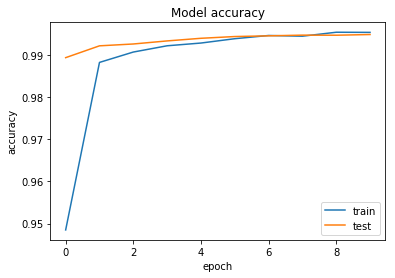

In [63]:
# Summarize history for accuracy

plt.plot(Trained_Model.history['acc'])
plt.plot(Trained_Model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

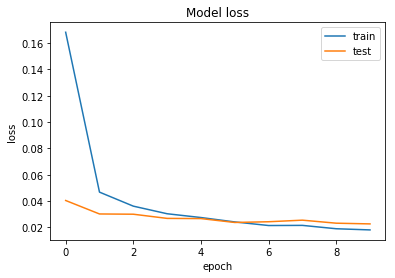

In [64]:
# Summarize history for loss

plt.plot(Trained_Model.history['loss'])
plt.plot(Trained_Model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Making Predictions
We can use our trained model to make predictions using model.predict

data  7897  :  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


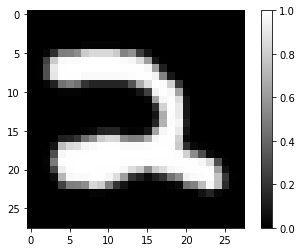

In [136]:
# Print the i data 
i = 7897
plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
plt.colorbar()
print('data ', i, ' : ', y_test[i])

In [137]:
# Use the model to make a prediction
predicted = model.predict(test)[0]
predicted_digit = np.argmax(predicted)+1
predicted_digit

10

In [107]:
filepath = "uploads/num3.png"

In [108]:
from keras.preprocessing import image
image_size = (28, 28)
im = image.load_img(filepath, target_size=image_size, grayscale=True)
im

C:\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [122]:
# Convert the image to a numpy array 
from keras.preprocessing.image import img_to_array
image = img_to_array(im)
image.shape

(28, 28, 1)

In [123]:
# Expand the dimension
image = np.expand_dims(image, axis=0)
image.shape

(1, 28, 28, 1)

In [124]:
# Scale the image pixels by 255 (or use a scaler from sklearn here)
image = (255 - image) / 255

In [125]:
# Use the model to make a prediction
predicted = model.predict(image)[0]
predicted_digit = np.argmax(predicted)+1
predicted_digit

3

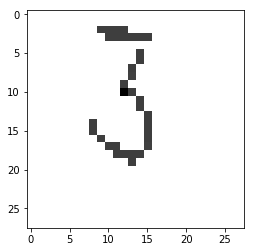

In [126]:
# Show the image
plt.imshow(image.reshape(28, 28), cmap=plt.cm.Greys)

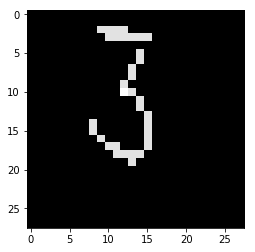

In [127]:
# Invert the pixel values to match the original data
image = 1 - image
plt.imshow(image.reshape(28, 28), cmap=plt.cm.Greys)